In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

### Preprocess Data

In [14]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='xl106_druckmaschine_30T', 
    freq=30,
    normalize_time=True
    )

### 30 minutes agg.

In [15]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.07, 0.11) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.17, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha

local_variation_2 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
    )

covar_module = locally_long_periodic  + local_variation 
#covar_module = locally_short_periodic + locally_long_periodic  + local_variation #+ local_variation_2

### Create, Train, and Perform Inference

Iter 1 , Loss = 1.0350103447106487 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.0066479216480524 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.9787639187726986 , Noise = 0.5982235074043274
Iter 4 , Loss = 0.9517276649070255 , Noise = 0.5544077754020691
Iter 5 , Loss = 0.9260543257357988 , Noise = 0.5130274891853333
Iter 6 , Loss = 0.9021250515237816 , Noise = 0.4740583300590515
Iter 7 , Loss = 0.8799843920779535 , Noise = 0.4374733567237854
Iter 8 , Loss = 0.8592941577930379 , Noise = 0.40324097871780396
Iter 9 , Loss = 0.8396373121731594 , Noise = 0.37132179737091064
Iter 10 , Loss = 0.8208460486783421 , Noise = 0.34166815876960754
Iter 11 , Loss = 0.8029914175838814 , Noise = 0.31422531604766846
Iter 12 , Loss = 0.7862342345312809 , Noise = 0.2889324426651001
Iter 13 , Loss = 0.7707206738465663 , Noise = 0.2657226622104645
Iter 14 , Loss = 0.756543657708109 , Noise = 0.2445227950811386
Iter 15 , Loss = 0.7437546904257027 , Noise = 0.22525285184383392
Iter 16 , Loss = 0.73237010815

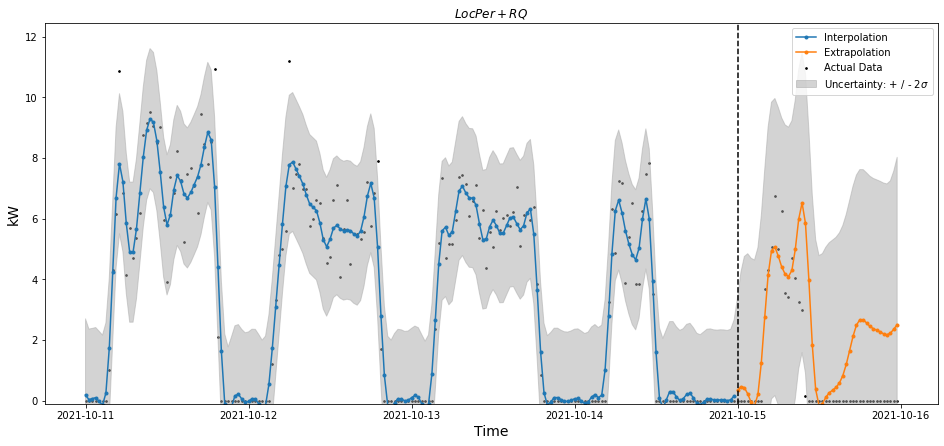

                 time     actual              machine
0 2021-10-11 05:00:00  10.875359  xl106_druckmaschine
1 2021-10-11 19:00:00  10.923694  xl106_druckmaschine
2 2021-10-12 06:00:00  11.181337  xl106_druckmaschine
3 2021-10-12 19:00:00   7.901908  xl106_druckmaschine


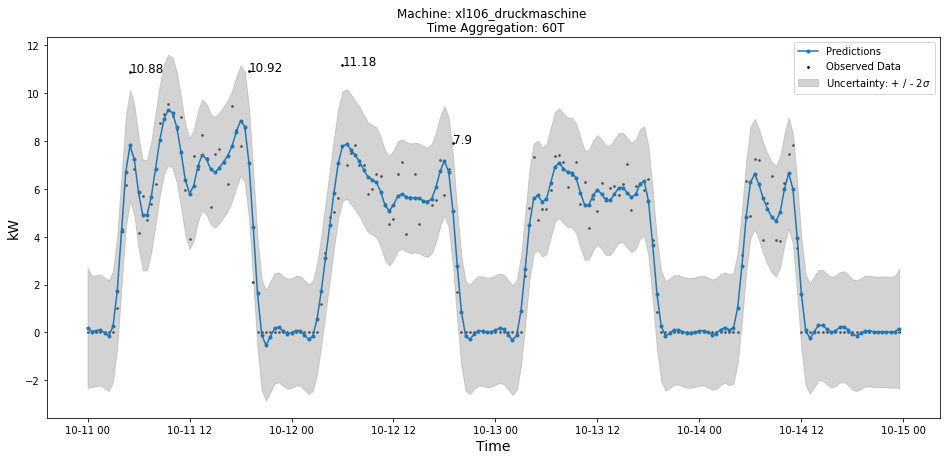

   index                time              machine control_limit  actual_kw  \
0      0 2021-10-15 10:00:00  xl106_druckmaschine         lower   0.156701   

   expected_kw     bound  
0     5.843609  0.906084  


/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:522: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:523: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:531: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[1].scatter(orig_time[c

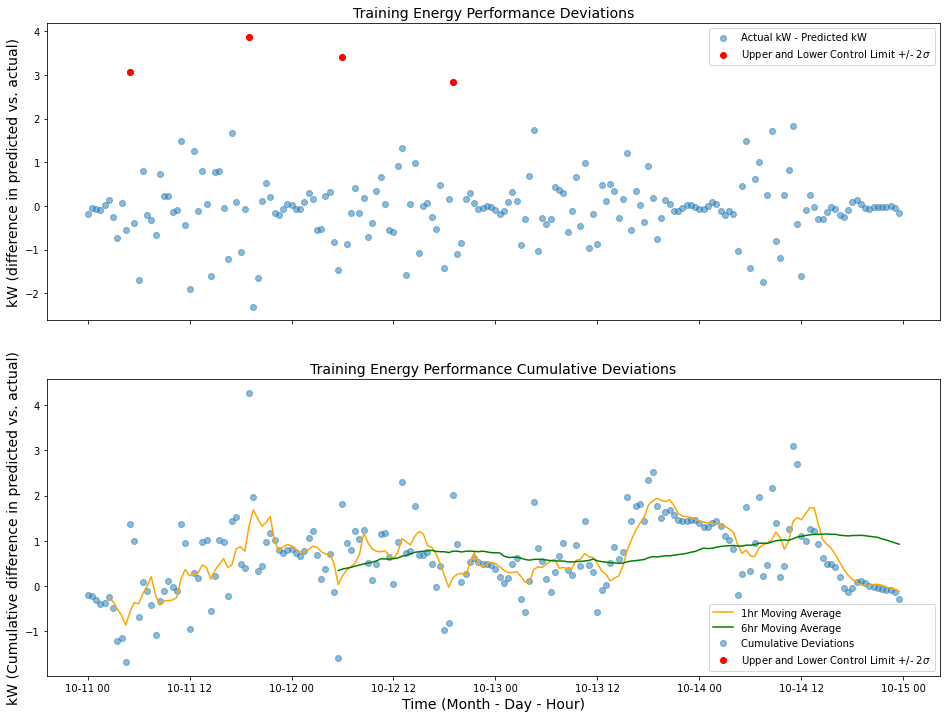

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:566: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_vals_upper], test_deviation[test_vals_upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:567: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_vals_lower], test_deviation[test_vals_lower], color='red')


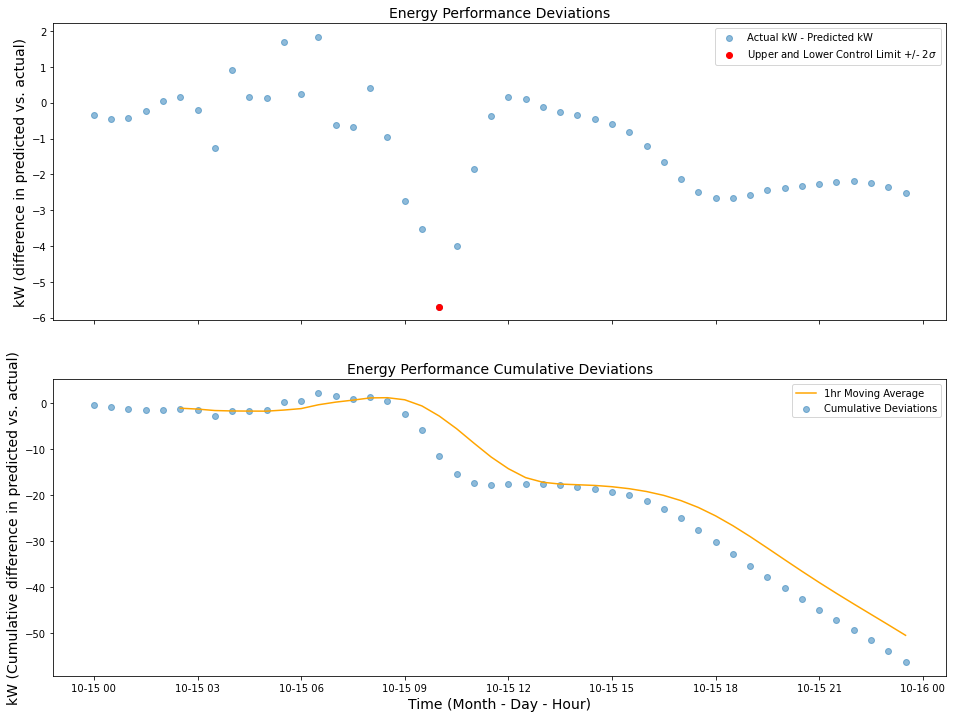

ValueError: Code kWh conversion for lower time aggregation

In [16]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='60T',
    lr=0.1, 
    machine='xl106_druckmaschine',
    update_score=False
)

In [5]:
mse, mape

(1.7626640870746577, 18879.181738928517)

### 10 minutes agg..

In [6]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='xl106_druckmaschine_10T', 
    freq=10,
    normalize_time=True
    )

In [7]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.06, 0.09) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.17, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_long_periodic + local_variation

Iter 1 , Loss = 0.9959820095447726 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.9657560682707089 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.9357260824570582 , Noise = 0.5982245206832886
Iter 4 , Loss = 0.9065155617390973 , Noise = 0.5544103384017944
Iter 5 , Loss = 0.8786790995738016 , Noise = 0.5130301713943481
Iter 6 , Loss = 0.852335918895773 , Noise = 0.47405683994293213
Iter 7 , Loss = 0.8271234550412474 , Noise = 0.4374561905860901
Iter 8 , Loss = 0.8026274931065802 , Noise = 0.40318188071250916
Iter 9 , Loss = 0.7788328251864262 , Noise = 0.37117519974708557
Iter 10 , Loss = 0.7561672444884577 , Noise = 0.34137073159217834
Iter 11 , Loss = 0.7351825713548594 , Noise = 0.31370246410369873
Iter 12 , Loss = 0.7161689900838305 , Noise = 0.2881065905094147
Iter 13 , Loss = 0.6989966727711524 , Noise = 0.26451942324638367
Iter 14 , Loss = 0.68332330971795 , Noise = 0.24287296831607819
Iter 15 , Loss = 0.6688950969714695 , Noise = 0.2230921983718872
Iter 16 , Loss = 0.65563728852

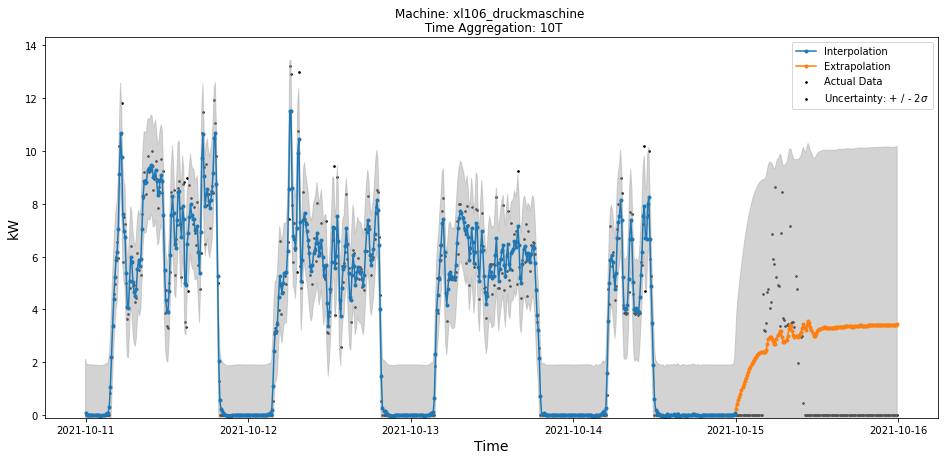

Abnormal High Energy Consumption
---------------------------------
2021-10-11T05:20:00.000000000 11.82376463318936
2021-10-11T15:00:00.000000000 8.993790714922655
2021-10-12T07:30:00.000000000 12.99755146550596
2021-10-12T12:40:00.000000000 9.448414149257147
2021-10-13T15:50:00.000000000 9.232876957712483
2021-10-14T10:30:00.000000000 10.201768571222875


Abnormal Low Energy Consumption
---------------------------------
2021-10-11T15:10:00.000000000 4.680831502321242
2021-10-14T10:40:00.000000000 4.712334785594899


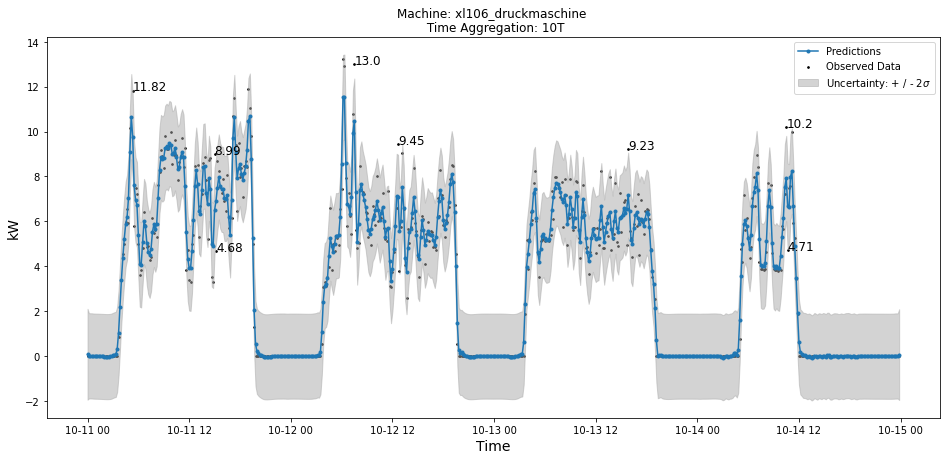

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:407: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:408: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.scatter(orig_time[lower], deviation[lower], color='red')


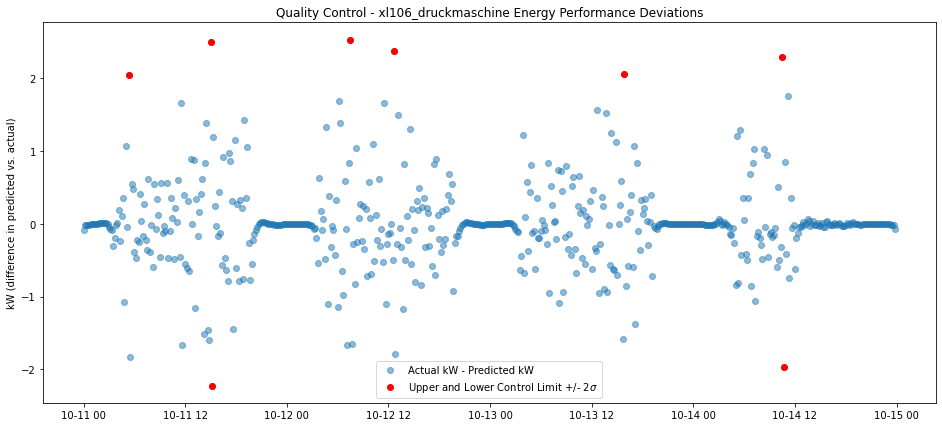

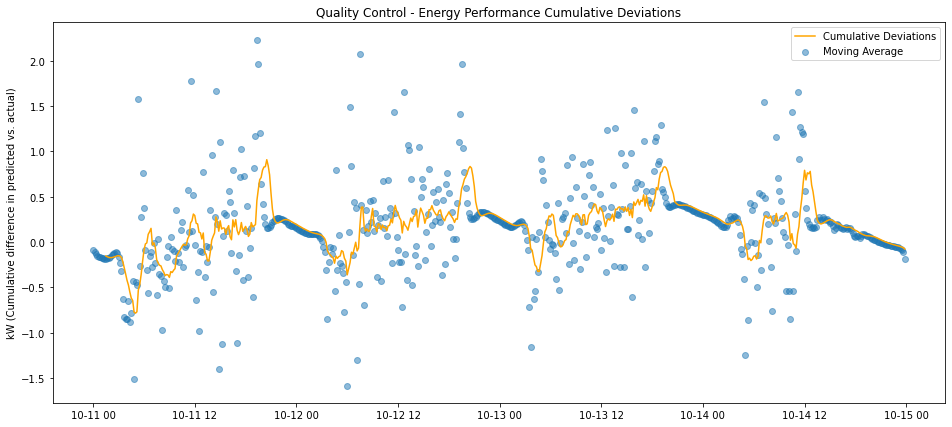

1.0 1.3036562454366878


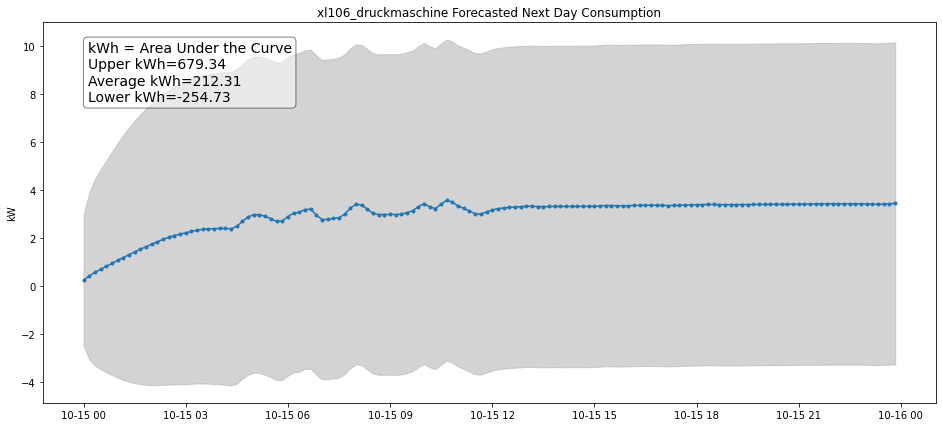

In [8]:
model, likelihood, mse, mape, perf_dev_upper = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='10T',
    lr=0.1, 
    machine='xl106_druckmaschine',
    update_score=False
)

In [54]:
mse, mape

(MultivariateNormal(loc: torch.Size([720])), 8.20710687337042)